# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
The goal of the project is to detect line marking on an image using Hough transformation.


## Pipeline description

### 1. Read an image
### 2. Convert the image to grayscale

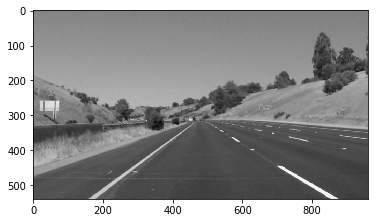

In [5]:
# 1. Read an image
input_img = mpimg.imread('test_images/solidYellowCurve2.jpg')
# 2. Convert to grayscal
gray_img = cv2.cvtColor(input_img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray_img, cmap='gray')

### 3. Reduce the noise on the image
To smooth the image we apply Gaussian blur. 5 by 5 kernel is the most often used value.

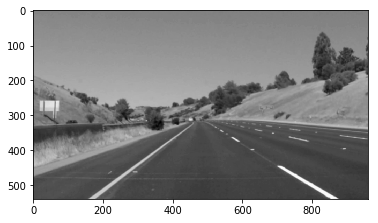

In [8]:
# 3. Blur the image
kernel_size = 5
blur_img = cv2.GaussianBlur(gray_img, (kernel_size, kernel_size), 0)
plt.imshow(blur_img, cmap='gray')

### 4. Apply Canny edge detection algorithm
Canny algorithm uses double threshold to detect strong, weak, and non-relevant pixels.
Pixels with value under low_threshold are non-relevant. Upper high_threshold are strong.
And between are weak. Such pixels can be labelled as strong if at least one of the pixels around the one being processed is a strong one.
Lane marking is in contrast with road. This allows us to choose high value for strong pixels  threshold.

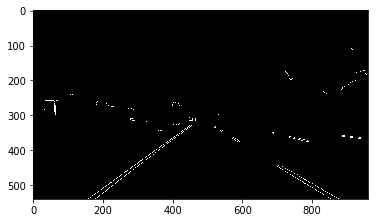

In [12]:
# 4. Apply canny algortihm
low_threshold = 150
high_threshold = 250
edge_img = cv2.Canny(blur_img, low_threshold, high_threshold)
plt.imshow(edge_img, cmap='gray')

### 5. Choose Region of interest

Crop the upper part of the image. It will also help to avoid the spot where lines start to converge (vanishing point).
This part depends on camera mounting position on a vehicle (it's pitch angle).

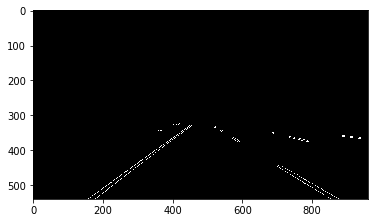

In [16]:
# 5. Apply the ROI
width = edge_img.shape[1]
height = edge_img.shape[0]
height_limit = 320 # chosen for provided test data
vertices = np.array( [[[0,height_limit],[width,height_limit],[width,height],[0,height]]], dtype=np.int32 )
cropped_img = region_of_interest(edge_img, vertices)
plt.imshow(cropped_img, cmap='gray')

### 6. Hough transformation

Each edge pixel will be transformed into line in Hough Space. The space is represented by a matrix
which parameters are determined by rho and theta. The bigger the matrix (rho increased) more line segments we will receive as a result. This matrix is also called accumulator. More lines cross in accumulator's cell, stronger the probability that there is a line with such rho and theta parameters in the image. We llok for local maxima in this matrix and return the set of lines. 
Further these lines are filtered out by maximum gap between points and minimum line lenght.

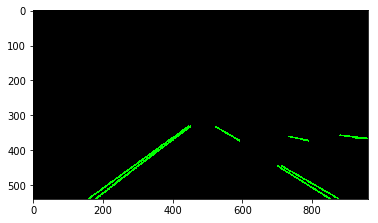

In [23]:
# 6. Apply Hough transformation on found edges
rho = 4 #number of rho values
theta = np.pi/180 #number of theta values
threshold = 100 #voting 
min_line_len = 30
max_line_gap = 30
hough_lines_result = cv2.HoughLinesP(cropped_img, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)
# Draw results
line_img = np.zeros((cropped_img.shape[0], cropped_img.shape[1], 3), dtype=np.uint8)
for line in hough_lines_result:
        for x1,y1,x2,y2 in line:
            cv2.line(line_img, (x1, y1), (x2, y2), [0, 255, 0], 3)
plt.imshow(line_img)

### 7. Filter by slope

As next step some lines can be filtered out if their slope is "too flat", they are perpendicular to driving direction. Also we can determine if line is left or right to the reference vehicle by slopes sign: positive - right; negative - left.

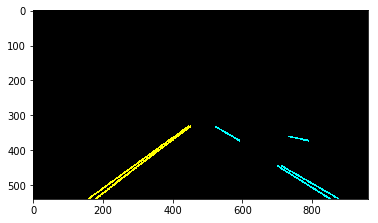

In [28]:
threshold = 0.15
left_lines = []
right_lines = []
for line in hough_lines_result:
    for x1,y1,x2,y2 in line:
        if (x2 - x1) == 0:
            continue
        slope = (y2 - y1) / (x2 - x1)
        if abs(slope) > threshold:
            if slope > 0:
                right_lines.append(line)
            else:
                left_lines.append(line)
# Draw results
line_img = np.zeros((cropped_img.shape[0], cropped_img.shape[1], 3), dtype=np.uint8)
for line in left_lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_img, (x1, y1), (x2, y2), [255, 255, 0], 3)
for line in right_lines:
    for x1,y1,x2,y2 in line:
        cv2.line(line_img, (x1, y1), (x2, y2), [0, 255, 255], 3)
plt.imshow(line_img)

### 8. Concatenate lines

Lines from the same side can be merged together. To avoid outliners distance between lines shall be checked first.

In [29]:
# Distance between lines
def line_dist(line1, line2):
    for x1_1,y1_1,x2_1,y2_1 in line1:
        p1=np.array([x1_1,y1_1])
        p2=np.array([x2_1,y2_1])
        for x1_2, y1_2, x2_2, y2_2 in line2:
            p3=np.array([x1_2,y1_2])
            p4=np.array([x2_2,y2_2])
            d1=np.linalg.norm(np.cross(p2-p1, p1-p3))/np.linalg.norm(p2-p1)
            d2=np.linalg.norm(np.cross(p2-p1, p1-p4))/np.linalg.norm(p2-p1)
            d = (d1+d2)/2
    return d 

In [30]:
def build_chains(input_lines, is_right, threshold = 20):
    """
    group lines into chains.
    We assume that all input lines are left or right
    """
    chains = []
    for line in input_lines:
        if len(chains) == 0:
            chains.append(line)
            continue
        was_added = False
        for chain in chains:          
                d = line_dist(line, chain)
                if d < threshold:
                    was_added = True
                    for x1_1,y1_1,x2_1,y2_1 in line:
                        for x1_2, y1_2, x2_2, y2_2 in chain:
                            if is_right == False:
                                chain[0][0] = min(x1_1, x2_1, x1_2, x2_2)
                                chain[0][1] = max(y1_1, y2_1, y1_2, y2_2)
                                chain[0][2] = max(x1_1, x2_1, x1_2, x2_2)
                                chain[0][3] = min(y1_1, y2_1, y1_2, y2_2)
                            else:
                                chain[0][0] = min(x1_1, x2_1, x1_2, x2_2)
                                chain[0][1] = min(y1_1, y2_1, y1_2, y2_2)
                                chain[0][2] = max(x1_1, x2_1, x1_2, x2_2)
                                chain[0][3] = max(y1_1, y2_1, y1_2, y2_2)
                            break
        if was_added == False:
            chains.append(line)
    return chains

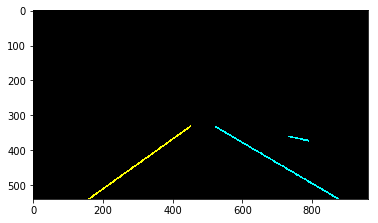

In [31]:
left_chains = build_chains(left_lines, False, 20)
right_chains = build_chains(right_lines, True, 20)
# Draw results
line_img = np.zeros((cropped_img.shape[0], cropped_img.shape[1], 3), dtype=np.uint8)
for line in left_chains:
    for x1,y1,x2,y2 in line:
        cv2.line(line_img, (x1, y1), (x2, y2), [255, 255, 0], 3)
for line in right_chains:
    for x1,y1,x2,y2 in line:
        cv2.line(line_img, (x1, y1), (x2, y2), [0, 255, 255], 3)
plt.imshow(line_img)

### 9. Choose the best line by slope and lenght parameters

As a final filter we again use slope value and hight (y difference) of lines

In [34]:
def find_highest_line(chains, threshold = 0.3):
    """
    calculate distance by y
    """
    if(len(chains) == 0):
        return chains
    result_idx = 0
    max_hight = 0
    for i in range(len(chains)):
        for x1,y1,x2,y2 in chains[i]:
            h = abs(y2-y1)
            slope = h / (x2 - x1) # we do not care about the sigh here
            if max_hight < h and slope > threshold:
                max_hight = h
                result_idx = i
    return chains[result_idx]

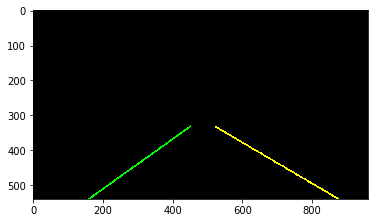

In [39]:
left_result = find_highest_line(left_chains)
right_result = find_highest_line(right_chains)
# Draw result
line_img = np.zeros((cropped_img.shape[0], cropped_img.shape[1], 3), dtype=np.uint8)
for x1,y1,x2,y2 in left_result:
        cv2.line(line_img, (x1, y1), (x2, y2), [0, 255, 0], 3)
for x1,y1,x2,y2 in right_result:
        cv2.line(line_img, (x1, y1), (x2, y2), [255, 255, 0], 3)
plt.imshow(line_img)

### 10. Apply results on original image

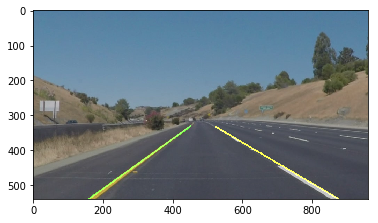

In [43]:
result_img = cv2.addWeighted(input_img, 0.8, line_img, 1., 0.)
plt.imshow(result_img)

## Reflection

